# Examples of Incremental AI: 
# Incremental k-means clustering
Many AI algorithms compute local minima. If the dataset changes only a little then the local minimum computed for the previous dataset is often a good place to start a search for the local minimum for the slightly changed dataset. 
<br>
<br>
Incremental k-means is merely an application of the k-means algorithm when a set of data points changes slightly. The cluster centers computed for a set of data points are used as the starting points in searching for cluster centers when the points change a little.
<br>
<br>
These examples have only one goal: show how to use programs in sklearn and other Python libraries with IoTPy to build streaming applications. So, the examples are very simple.
<br>
<br>
This notebook is a tutorial into incremental clustering using k-means. The initial part of this notebook is about k-means in general, and does not use IoTPy. <i>To see how IoTPy uses k-means from the sklearn library jump to the heading <b>Part 2: IoTPy</b></i>.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling
import numpy as np
import threading
import time
from sklearn.datasets.samples_generator import make_blobs
from sklearn.cluster import KMeans

import sys
sys.path.append("../")
from IoTPy.core.stream import Stream, StreamArray, run
from IoTPy.agent_types.op import map_window, map_element
from IoTPy.agent_types.sink import sink_element
from examples.K_Means.kmeans import normally_distributed_points

from IoTPy.concurrency.multicore import get_processes, get_processes_and_procs
from IoTPy.concurrency.multicore import terminate_stream
from IoTPy.concurrency.multicore import get_proc_that_inputs_source
from IoTPy.concurrency.multicore import extend_stream

# Part 1: Introduction to Random Points & Plots
<b>To see incremental k-means in IoTPy jump to <i>Part 2: IoTPy.</i></b>
<br>
<br>
This next section does not use IoTPy; it is a simple introduction to a program in the sklearn library for generating random points with a normal distribution with specified centers and standard deviations, and an introduction to clustering using k-means. You can skip the introduction and jump to Part 2.
<br>
<br>
This section shows how we generate points around specified centers. Here we have four centers at the four corners of a square. [1.0, 1.0], [1.0, -1.0], [-1.0, -1.0], [-1.0, 1.0]
<br>
<br>
When we compute the centers of clusters using <b>kmeans</b> we find that the centers determined by <b>kmeans</b> are different from the centers used to generate random points.
<br>
<br>
Then we change the points a little, adding some points and taking some points out. The new points that we add are around the specified centers [1.0, 1.0], [1.0, -1.0], ... So the points change but are from the same distribution. We can then look at how the clusters change as points change.
<br>
<br>
As you may expect, if the set of points change by adding a <i>single</i> point and taking out a <i>single</i> point, then the clusters change less than if several points are added and taken out.
<br>
<br>
You can run these programs with different values of standard deviation and see how that impacts changing clusters.

# Parameters for creating random points around centers

In [2]:
# CREATE POINTS IN BLOBS AROUND CENTERS
# centers is the list of centers of the blobs.
CENTERS = np.array([[1.0, 1.0], [1.0, -1.0], 
                    [-1.0, -1.0], [-1.0, 1.0]])
# n_features is the number of features which is also the dimension 
# of the space.
n_features=2
# n_centers is the number of centers.
n_centers = len(CENTERS)
# n_samples is the number of points.
n_samples=20
# cluster_std is the standard deviation of points around the centers.
stdev = 0.2

# Sklearn function to generate random points

In [3]:
# Create the points
points, blob_cluster_ids = make_blobs(
    n_samples, n_features, centers=CENTERS, 
    cluster_std=stdev, random_state=0)
# random_state=0 starts random number generator from the same 
# initial value for every run.
# points is the set of points in the blobs
# centers[blob_cluster_ids[i]] is the center that generated points[i]

In [4]:
# Use kmeans to cluster points into n_cluster clusters.
n_clusters = 4
kmeans = KMeans(n_clusters)

# Function to compute kmeans and plot clusters.

In [5]:
# Function to compute k-means cluster, plot clusters and centers, and
# return centers.
def plot_clusters_and_return_centers(points):
    kmeans.fit(points)
    # cluster_ids[j] is the id of the cluster associated with points[j].
    cluster_ids = kmeans.predict(points)
    # Plot the points. The parameter c identifies colors of points.
    plt.scatter(points[:, 0], points[:, 1], c=cluster_ids, 
                s=50, cmap='viridis')

    # Plot the centers of the clusters computed by k-means.
    # kmeans.cluster_centers_ is the list of computed centers
    # of the clusters
    centers = kmeans.cluster_centers_
    plt.scatter(centers[:, 0], centers[:, 1], c='black', 
                s=50, alpha=0.5);
    plt.show()
    return centers

# Function to change the point set by a few points

In [6]:
# FUNCTION TO CHANGE THE POINT SET BY A FEW POINTS
# Generate more points around the centers. The number of points
# generated is n_more_points
# Create a sliding window in which n_more_points are generated around
# each center, and the previous n_more_points*n_clusters points are 
# removed.
n_more_points=2
def change_points(points, n_more_points, n_clusters):
    for center in CENTERS:
        # points_around_center is list of n_more_points points 
        # distributed normally around the theoretical centers.
        # Create new points
        new_points, new_blob_cluster_ids = make_blobs(
            n_more_points, n_features, centers=CENTERS, 
            cluster_std=stdev, random_state=0)
        #points_around_center = normally_distributed_points(
            #center, stdev=stdev, num_points=n_more_points)
        # Append these new points to the previous set of points.
        points = np.append(points, new_points, axis=0)
    # Remove earlier points from the set of points.
    # Since we added n_more_points to each cluster, we remove
    # n_more_points*n_clusters.
    points = points[n_more_points*n_clusters:]
    return points

# Plot points and theoretical cluster centers

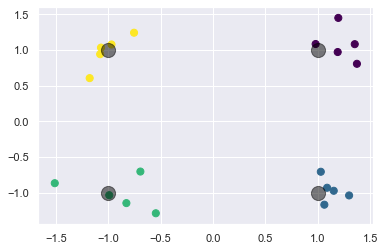

In [7]:
# Plot points where color of a point is associated with 
# the cluster center that generated that point.
plt.scatter(points[:, 0], points[:, 1], 
            c=blob_cluster_ids, s=50, cmap='viridis');
# Plot the centers around which the blobs were generated.
plt.scatter(CENTERS[:, 0], CENTERS[:, 1], c='black', s=200, alpha=0.5);

# Plot points and k-means cluster centers

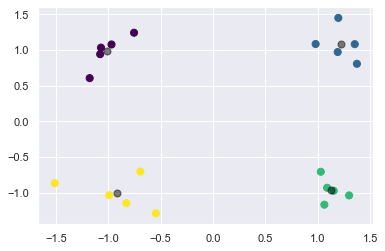

array([[-1.00951146,  0.97815168],
       [ 1.21828872,  1.07692055],
       [ 1.12624365, -0.96598525],
       [-0.91361045, -1.01042949]])

In [8]:
# Plot points where color of a point is determined by 
# the kmeans cluster associated with that point.
# Note that previously we associated the color of a point with 
# the center that generated the point. This is the theoretical center.
# In this plot the color is associated with the cluster center computed 
# using kmeans. 
# The theoretical centers of the clusters are likely to be
# different from the centers computed by kmeans.
plot_clusters_and_return_centers(points)

# Change points and recompute cluster centers.

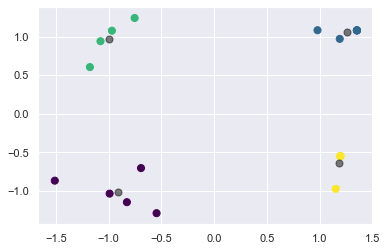

array([[-0.91361045, -1.01042949],
       [ 1.26343596,  1.06199567],
       [-0.99449372,  0.96487216],
       [ 1.18703959, -0.63659009]])

In [9]:
points = change_points(points, n_more_points, n_clusters)
plot_clusters_and_return_centers(points)

# Part 2: Incremental k-means in IoTPy
We use a sliding window to see how clusters change as the set of points changes. We will first test windows and agents and later create a multiprocess program.
## Part 2 a: Testing streams and agents.

In [10]:
def test_kmeans(n_steps, n_more_points, 
                n_samples, n_features, CENTERS, stdev):
    # Create streams
    stream_of_points = StreamArray(
        name='stream_of_points', dimension=n_features)
    stream_of_centers = Stream(name='stream_of_centers')

    # Create agents
    map_window(func=plot_clusters_and_return_centers,
               in_stream=stream_of_points,
               out_stream=stream_of_centers,
               window_size=n_samples,
               step_size=n_more_points);
    sink_element(func=lambda v: print ('center: \n', v), 
                 in_stream=stream_of_centers);

    # Start the computation.
    # First extend the stream with points around the true centers.
    # Compute points around true centers.
    points, blob_cluster_ids = make_blobs(
        n_samples, n_features, 
        centers= CENTERS, cluster_std=stdev, random_state=0)
    stream_of_points.extend(points)
    # Sleep to mimic a stream coming from an external source.
    time.sleep(0.001)
    run()
    # Extend the stream with n_more_points at each step.
    for i in range(n_steps-1):
        # Compute points to be added to the stream.
        new_points, new_blob_cluster_ids = make_blobs(
            n_more_points, n_features, centers=CENTERS, 
            cluster_std=stdev, random_state=0)
        # Extend the stream with the new points and run.
        stream_of_points.extend(new_points)
        # Sleep to mimic a stream coming from an external source.
        time.sleep(0.001)
        run()

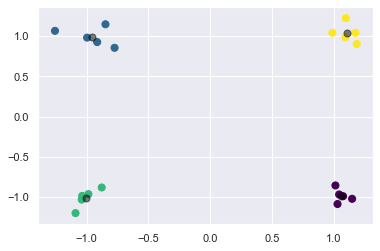

center: 
 [[ 1.06312183 -0.98299262]
 [-0.95680523  0.99478526]
 [-1.00475573 -1.01092416]
 [ 1.10914436  1.03846028]]


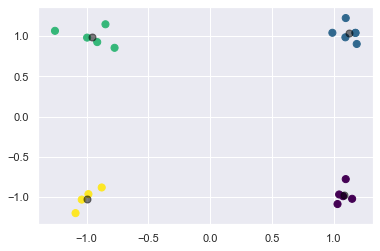

center: 
 [[ 1.07981571 -0.96726023]
 [ 1.1203545   1.03871952]
 [-0.95680523  0.99478526]
 [-0.99724686 -1.01756392]]


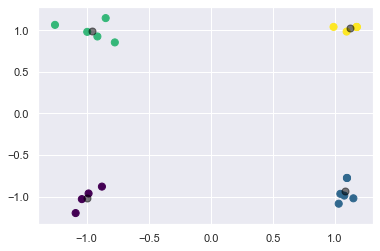

center: 
 [[-0.99724686 -1.01756392]
 [ 1.0828254  -0.93536864]
 [-0.95680523  0.99478526]
 [ 1.12278053  1.02919426]]


In [11]:
test_kmeans(n_steps=3, n_more_points=2, n_samples=20, n_features=2,
            CENTERS= np.array(
                [[1.0, 1.0], [1.0, -1.0], [-1.0, 1.0], [-1.0, -1.0]]), 
            stdev=0.1)

# A Multiprocessor Implementation
![alt text](ExamplesKMeans.jpg "Multiprocessor Diagram")

In [12]:
# Step 0: Define agent functions, source threads 
# and actuator threads (if any).

# Step 0.0: Define agent functions.
# kmeans_agent is the agent for the process called ComputeKmeansProcess.
def kmeans_agent(in_streams, out_streams):
    def h(window):
        print ('plot')
        return plot_clusters_and_return_centers(np.array(window))
    map_window(func=h,
               in_stream=in_streams[0],
               out_stream=out_streams[0],
               window_size=n_samples,
               step_size=n_more_points);

# print_centers_agent is the agent for the process called
# PrintCentersProcess.
def print_centers_agent(in_streams, out_streams):
    sink_element(func=lambda v: print ('center: \n', v), 
                 in_stream=in_streams[0]);

# Step 0.1: Define source thread target.
n_steps = 2
def generate_points_thread_target(procs):
    # Create a set of random points around CENTERS
    points, blob_cluster_ids = make_blobs(
        n_samples, n_features, centers=CENTERS, 
        cluster_std=stdev, random_state=0)
    
    # Add points incrementally.
    for _ in range(n_steps):

        points_as_list_of_lists = list([
            list(v) for v in points
        ])
        # Extend stream with these additional points
        #extend_stream(procs, data=points_as_list_of_lists, 
                      #stream_name='stream_of_points')
        extend_stream(procs, data=points, 
                      stream_name='stream_of_points')
        time.sleep(0.001)

        # Create additional random points around CENTERS
        points, blob_cluster_ids = make_blobs(
            n_more_points, n_features, centers=CENTERS, 
            cluster_std=stdev, random_state=0)

    # Terminate stream because the stream will not be extended
    # further.
    terminate_stream(procs, stream_name='stream_of_points')
    

plot


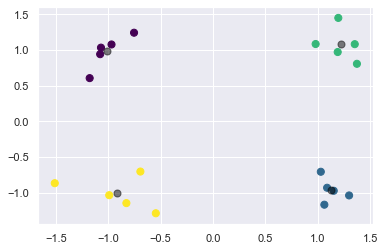

plot
center: 
 [[-1.00951146  0.97815168]
 [ 1.12624365 -0.96598525]
 [ 1.21828872  1.07692055]
 [-0.91361045 -1.01042949]]


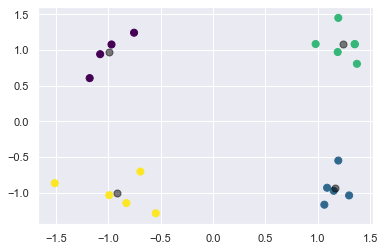

center: 
 [[-0.99449372  0.96487216]
 [ 1.15963143 -0.93452046]
 [ 1.24070901  1.07743903]
 [-0.91361045 -1.01042949]]


In [13]:
# Step 1: multicore_specification of streams and processes.
# Specify Streams: list of pairs (stream_name, stream_type).
# Specify Processes: name, agent function, 
#       lists of inputs and outputs and sources, additional arguments.
multicore_specification = [
    # Streams
    [('stream_of_points', 'x'), ('stream_of_centers', 'x')],
    # Processes
    [{'name': 'ComputeKmeansProcess', 'agent': kmeans_agent, 
      'inputs':['stream_of_points'], 'sources':['stream_of_points'],
      'outputs': ['stream_of_centers']},
     {'name': 'PrintCentersProcess', 'agent': print_centers_agent, 
      'inputs':['stream_of_centers']},
    ]]

# Step 2: Create processes.
processes, procs = get_processes_and_procs(multicore_specification)

# Step 3: Create threads (if any)
generate_points_thread = threading.Thread(
    target=generate_points_thread_target, args=(procs,))

# Step 4: Specify which process each thread runs in.
# thread_0 runs in the process called 'coordinator'
procs['Compute_kmeans'].threads = [generate_points_thread]

# Step 5: Start, join and terminate processes.
for process in processes: process.start()
for process in processes: process.join()
for process in processes: process.terminate()